# A quick look at a few examples

this is not a systematic study, just a quick look at a few examples that came out of the simple step detectrion

In [3]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq,practice # my local stuff
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [1]:
from sklearn.decomposition import PCA
def principal_components_report(crosstab,ncts=3,minw=0.1):
    pca=PCA()
    pca.fit(crosstab)
    for i,princomp in enumerate(range(ncts)):
        print "\tPrincipal component %i - explains %.2f%% of the variance:\n" % (princomp,100*pca.explained_variance_ratio_[i])
        
        chems=list()
        for i,w in enumerate(pca.components_[princomp]):

            if abs(w)>minw:
                chems.append((abs(w),w,"%s (%s)" % (bnf.path(crosstab.columns[i])[-1],crosstab.columns[i])))
        for a,w,c in sorted(chems,reverse=True):
            print "\t\t%s: %s" % (c,w)
        print

# Ergocalciferol

In [31]:
df=gbq.query(
    '''
    select left(bnf_code,9) chemical,TIMESTAMP_TO_MSEC(month) month,pct,sum(actual_cost) total_cost,sum(items) total_items
    from [hscic.prescribing]
    where left(bnf_code,7)="0906040"
    group by chemical,pct,month
    ''',
    max_rows=500000,index=['pct','chemical','month'],
    cast={'total_cost':float,'total_items':float,'month':lambda t:datetime.fromtimestamp(int(t)/1000)},
    cachedir='/var/gbq',dirty=False
)

Reading cached results from /var/gbq/0a3799218ff9d0eabb58bb7970499bd5.json
49704 rows converted to DataFrame in 0.30 seconds


There are only a few chemicals in this bnf paragraph so let's just plot all of them

In [34]:
df.groupby(level=1).sum()

,total_cost,total_items
chemical,,
0906040B0,3.332044e+07,4126619
0906040C0,2.834019e+06,276852
0906040G0,3.006211e+08,67467167
0906040K0,7.320457e+04,965
0906040N0,8.587199e+07,16636836
0906040P0,5.887253e+05,6210


It looks like Ergocalciferol was dropped in favour of Colecalciferol

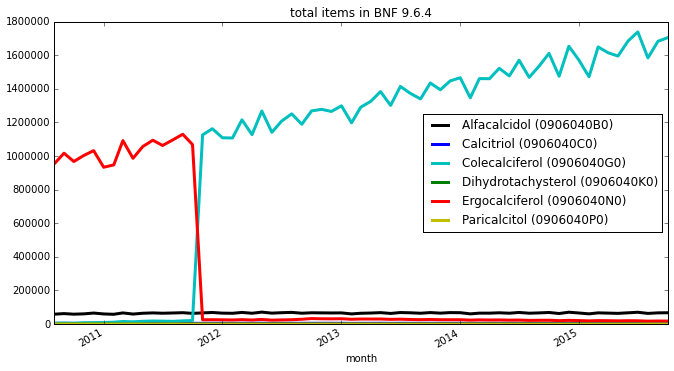

In [5]:
x=df['total_items'].groupby(level=(1,2)).sum().unstack(0)
x.columns=x.columns.map(lambda i: "%s (%s)" % (bnf.path(i)[-1],i))
x.plot(legend=True,linewidth=3,color='kbcgry',figsize=(11,6),title="total items in BNF 9.6.4")

# Erpanutin

http://www.epilepsysociety.org.uk/Changes-epanutin-phenytoin-capsules-flynn-pharma-18-09-2012#.VqTHy5OLS34

In [147]:
df=gbq.query(
    '''
    select bnf_code product,TIMESTAMP_TO_MSEC(month) month,sum(actual_cost) total_cost,sum(items) total_items
    from [hscic.prescribing]
    where left(bnf_code,9)="0408010Q0"
    group by product,month
    ''',
    max_rows=500000,index=['product','month'],
    cast={'total_cost':float,'total_items':float,'month':lambda t:datetime.fromtimestamp(int(t)/1000)},
    cachedir='/var/gbq',dirty=False
)

Reading cached results from /var/gbq/886e8c7d878abfa1f0808a3d25d6eb7e.json
689 rows converted to DataFrame in 0.01 seconds


In [148]:
principal_components_report(df.unstack(0)['total_items']['2012-06-01':'2013-06-01'].fillna(0),ncts=3,minw=0.1 )

	Principal component 0 - explains 98.74% of the variance:

		Epanutin_Cap 100mg (0408010Q0BBAEAA): 0.692374794279
		Phenytoin_Sod Cap 100mg (0408010Q0AAAAAA): -0.640305957601
		Epanutin_Cap 50mg (0408010Q0BBADAP): 0.178570363008
		Phenytoin_Sod Cap 50mg (0408010Q0AAAPAP): -0.173122523383
		Epanutin_Cap 300mg (0408010Q0BBAFAQ): 0.131153551915
		Phenytoin_Sod Cap 300mg (0408010Q0AAAQAQ): -0.127458765759

	Principal component 1 - explains 1.23% of the variance:

		Phenytoin_Sod Cap 100mg (0408010Q0AAAAAA): -0.627319514962
		Epanutin_Cap 100mg (0408010Q0BBAEAA): -0.623452863324
		Phenytoin_Sod Tab 100mg (0408010Q0AAAGAG): -0.283226922617
		Phenytoin_Sod Cap 50mg (0408010Q0AAAPAP): -0.219072477489
		Phenytoin_Sod Cap 300mg (0408010Q0AAAQAQ): -0.207082333567
		Epanutin_Cap 50mg (0408010Q0BBADAP): -0.141718680864
		Phenytoin_Sod Cap 25mg (0408010Q0AAADAD): -0.106773676667

	Principal component 2 - explains 0.02% of the variance:

		Phenytoin_Sod Cap 50mg (0408010Q0AAAPAP): 0.699758183819
		Ph

In [149]:
df['unit_cost']=df['total_cost']/df['total_items']
df.index=pd.MultiIndex.from_tuples(df.index.map(lambda i:(bnf.path(i[0])[-1],i[1])))

(0, 87)

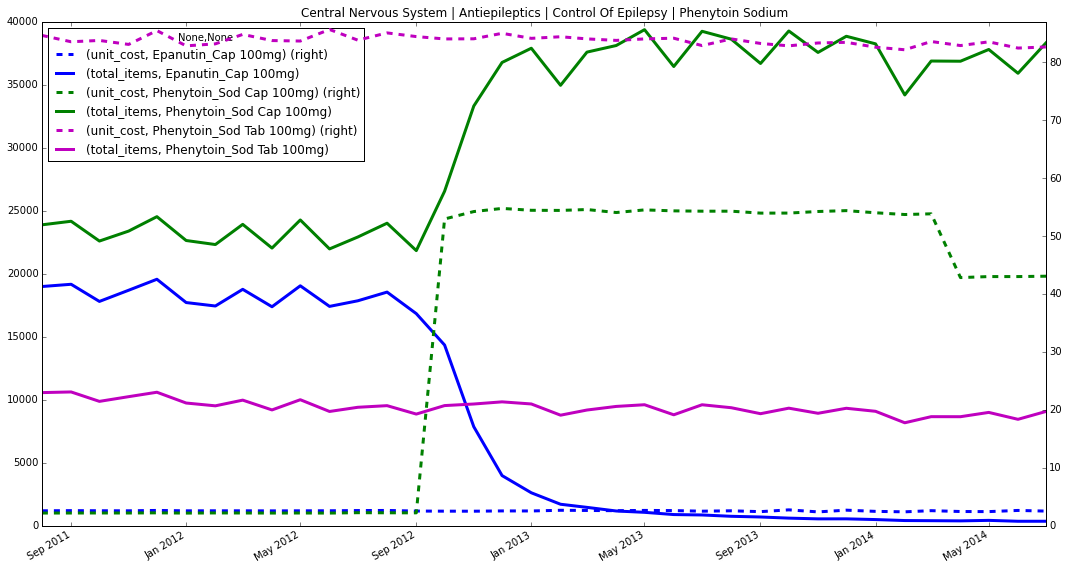

In [163]:
presentations=map(lambda i:bnf.path(i)[-1],"0408010Q0BBAEAA,0408010Q0AAAAAA,0408010Q0AAAGAG".split(','))
cols=list()
costcols=list()
for p in presentations:
    cols.append(('unit_cost',p))
    costcols.append(('unit_cost',p))
    cols.append(('total_items',p))

ax=df.unstack(0)[cols].fillna(0)[12:48].plot(legend=True,style=['--','-']*len(presentations),color='bbggmmcc',
                             secondary_y=costcols,
                             figsize=(18,10),linewidth=3,title=bnf.description('0408010Q0'))

ax.set_ylim(0)
ax.right_ax.set_ylim((0,87))

# Cerazette 0703021Q0BB

In [164]:
df=gbq.query(
    '''
    select left(bnf_code,11) product,TIMESTAMP_TO_MSEC(month) month,sum(actual_cost) total_cost,sum(items) total_items
    from [hscic.prescribing]
    where left(bnf_code,7)="0703021"
    group by product,month
    ''',
    max_rows=500000,index=['product','month'],
    cast={'total_cost':float,'total_items':float,'month':lambda t:datetime.fromtimestamp(int(t)/1000)},
    cachedir='/var/gbq',dirty=False
)

Reading cached results from /var/gbq/764971c67df507cb55fcdf8547b60919.json
801 rows converted to DataFrame in 0.01 seconds


In [165]:
principal_components_report(df.unstack(0)['total_items'].fillna(0),ncts=5,minw=0.1)

	Principal component 0 - explains 91.60% of the variance:

		Cerelle (0703021Q0BD): 0.734689137088
		Cerazette (0703021Q0BB): -0.576589282383
		Desogestrel (0703021Q0AA): 0.333112360312
		Femulen (0703021C0BB): -0.10830659905

	Principal component 1 - explains 6.54% of the variance:

		Cerazette (0703021Q0BB): 0.7696888902
		Desogestrel (0703021Q0AA): 0.495316123512
		Cerelle (0703021Q0BD): 0.348679271584
		Femulen (0703021C0BB): -0.177776738587

	Principal component 2 - explains 1.42% of the variance:

		Desogestrel (0703021Q0AA): -0.766117396515
		Cerelle (0703021Q0BD): 0.481602950651
		Femulen (0703021C0BB): -0.301520998924
		Cerazette (0703021Q0BB): 0.217718592516
		Micronor (0703021N0BB): 0.143158293832

	Principal component 3 - explains 0.33% of the variance:

		Micronor (0703021N0BB): 0.855858792129
		Femulen (0703021C0BB): 0.320842338593
		Noriday (0703021N0BC): 0.319233519342
		Norethist (Contracep) (0703021N0AA): 0.171670642152
		Desogestrel (0703021Q0AA): 0.12614974368

	Pri

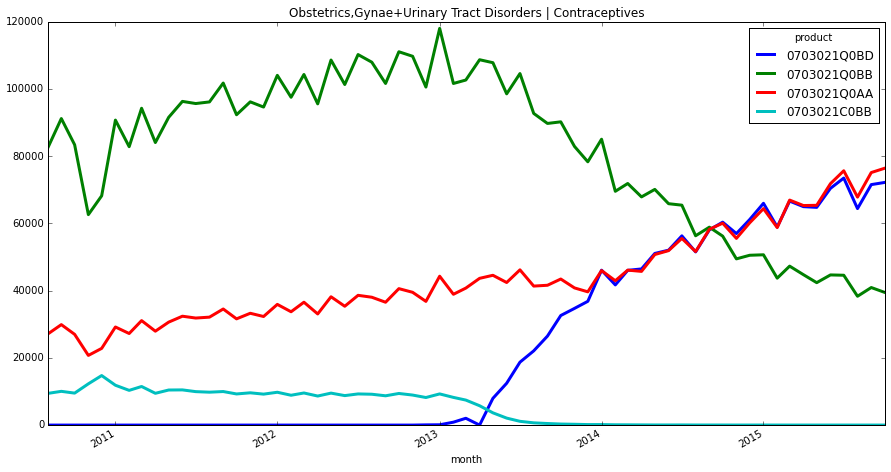

In [166]:
df.unstack(0)['total_items'][['0703021Q0BD','0703021Q0BB','0703021Q0AA','0703021C0BB']].fillna(0).plot(legend=True,
                                                                                  figsize=(15,8),linewidth=3,
                                                                                  title=bnf.description('0703')
                                                                                 )